In [1]:
from datetime import datetime
import functools
import glob
import h5py
import matplotlib
from matplotlib import animation, cm, transforms, pyplot as plt, gridspec as grd
from matplotlib.collections import PathCollection
import numba
import numpy as np
from ripser import Rips, ripser
from scipy import stats, signal, optimize
from scipy.optimize import minimize
import scipy.io as sio
from scipy.ndimage import (
    gaussian_filter,
    gaussian_filter1d,
    rotate,
    binary_dilation,
    binary_closing,
)
from scipy.stats import binned_statistic_2d, pearsonr, multivariate_normal
from scipy.special import factorial
from scipy.spatial.distance import cdist, pdist, squareform
import scipy.stats
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score
import sys
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.metrics import pairwise_distances
import umap
import matplotlib.pyplot as plt
import torch
import os
import plotly.graph_objects as go
from utils import get_coords, plot_diagrams
from gudhi.clustering.tomato import Tomato
from collections import Counter

Import the data. "activity" is then a 40000x512 matrix with all activations.

In [2]:
activity = torch.load("activations/ILSVRC2015/inception4a.pt").detach().numpy()
print(activity.shape)

(50761, 512)


Use UMap to project to 2D

In [3]:
# Fixing umap bug. https://gitmetadata.com/repo/lmcinnes/pynndescent/issues/163


@numba.njit(fastmath=True)
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result


import pynndescent

pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

In [4]:
layout_2d = umap.UMAP(
    n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Wed Feb  9 21:04:04 2022 Construct fuzzy simplicial set
Wed Feb  9 21:04:04 2022 Finding Nearest Neighbors
Wed Feb  9 21:04:04 2022 Building RP forest with 16 trees
Wed Feb  9 21:04:05 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations
Wed Feb  9 21:04:11 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:04:13 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb  9 21:04:35 2022 Finished embedding


In [5]:
layout = umap.UMAP(
    n_components=512, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=512, n_neighbors=20, verbose=True)
Wed Feb  9 21:04:35 2022 Construct fuzzy simplicial set
Wed Feb  9 21:04:35 2022 Finding Nearest Neighbors
Wed Feb  9 21:04:35 2022 Building RP forest with 16 trees
Wed Feb  9 21:04:36 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Wed Feb  9 21:04:38 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:04:38 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb  9 21:12:42 2022 Finished embedding


Cluster the UMap output with kMeans to get 10 cluster. Then visualize.

In [10]:
kmeans = KMeans(9, random_state=42)
clusters = kmeans.fit_predict(layout)
# clusters=kmeans.fit_predict(activity)

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/point_cloud/dtm.py:168: RuntimeWarning: divide by zero encountered in reciprocal
  density = dtm ** (-dim / q)
/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/point_cloud/dtm.py:168: RuntimeWarning: overflow encountered in reciprocal
  density = dtm ** (-dim / q)


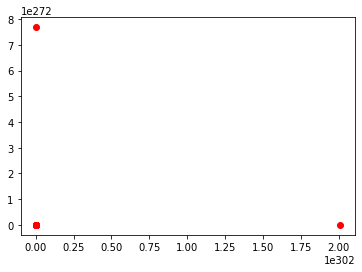

In [20]:
t = Tomato(density_type="DTM", k=100)
clusters = t.fit_predict(layout)
t.plot_diagram()

In [21]:
print(t.n_clusters_)
print(Counter(t.labels_).most_common(10))

200
[(55, 3523), (183, 2379), (44, 1442), (15, 1391), (184, 1383), (63, 1294), (31, 1132), (126, 851), (109, 818), (90, 809)]


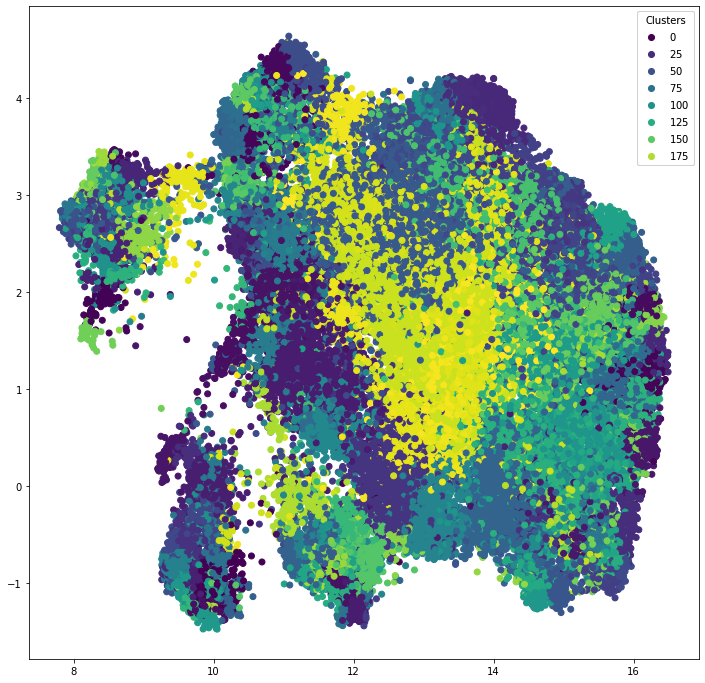

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1], c=t.labels_)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

In cluster 7 there is a circle in the activations. To see it we apply UMAp as a prepocessing step. Then it's visible with persistent homology. 

In [27]:
cluster = []
for n in range(len(clusters)):
    if clusters[n] in [183]:
        cluster.append(activity[n])
cluster = np.array(cluster)
print(cluster.shape)

(2379, 512)


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=512, n_neighbors=20, verbose=True)
Wed Feb  9 21:25:01 2022 Construct fuzzy simplicial set
Wed Feb  9 21:25:04 2022 Finding Nearest Neighbors
Wed Feb  9 21:25:04 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:25:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 21:25:17 2022 Finished embedding


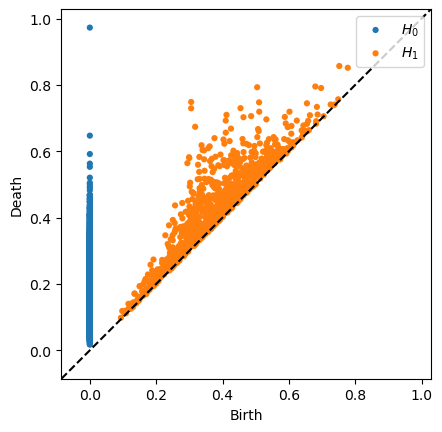

In [28]:
layout2 = umap.UMAP(
    n_components=512, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
fig, ax = plt.subplots()
plot_diagrams(persistence["dgms"], plot_only=np.arange(maxdim + 1), ax=ax, show=True)

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [29]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

f, verts = get_coords(cocycle, threshold, len(layout2), M, 47)

print(len(f))

2379


Visualize it after projecting to 3d: 

In [30]:
layout_3d = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="Viridis", opacity=0.8, showscale=True
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D.html")
fig.show()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb  9 21:25:43 2022 Construct fuzzy simplicial set
Wed Feb  9 21:25:45 2022 Finding Nearest Neighbors
Wed Feb  9 21:25:45 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:25:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 21:25:47 2022 Finished embedding


Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

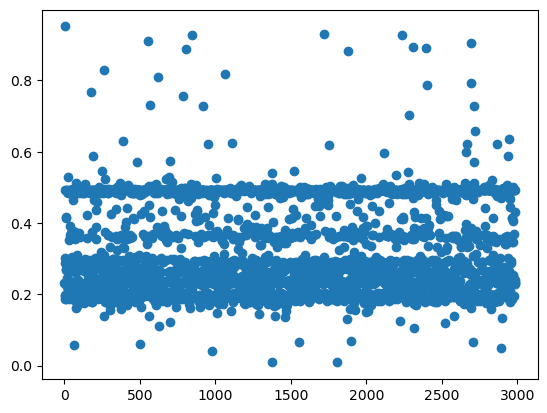

In [25]:
plt.scatter(y=f, x=verts)

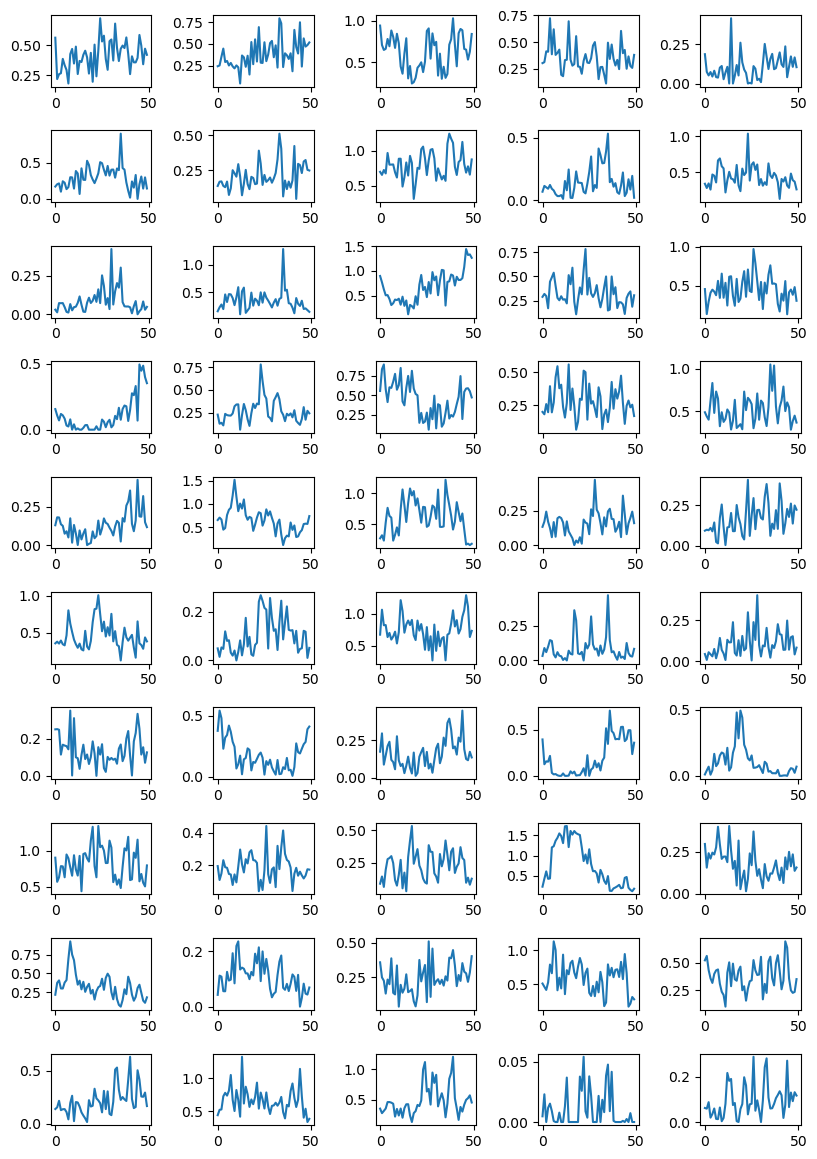

In [31]:
circ_rates = np.zeros([512, 50])
bins = np.linspace(0, 1, 51)
for b in range(len(bins) - 1):
    for n in range(512):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0

fig, axs = plt.subplots(10, 5, figsize=(8.27, 11.69))
for n in range(5):
    for m in range(10):
        axs[m, n].plot(range(50), circ_rates[m * 5 + n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

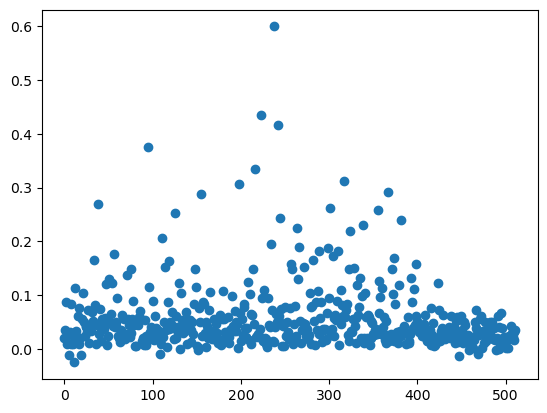

In [33]:
def inform_rate(mean_n, data, coun):
    m = []
    for b in range(50):
        m.append(data[b])
    return np.sum(m * np.log2((m / mean_n) + 0.0000001) * coun)


mean = np.zeros(512)
for n in range(512):
    mean[n] = np.mean(cluster[:, n])

counts = []
for b in range(50):
    count = 0
    for p in f:
        if b / 51 < p < (b + 1) / 51:
            count += 1
    counts.append(count / len(f))

inform_rates = []
for n in range(512):
    inform_rates.append(inform_rate(mean[n], circ_rates[n, :], counts))

plt.scatter(range(len(inform_rates)), inform_rates)
plt.show()

Then we pick the ones with an information rate higher then 0.2:

In [34]:
high_inform = np.where(np.array(inform_rates) > 0.2)[0]
len(high_inform)

19

Lets compute everything again but just with these neurons:

In [35]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > 0.2)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > 0.2)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb  9 21:26:54 2022 Construct fuzzy simplicial set
Wed Feb  9 21:26:55 2022 Finding Nearest Neighbors
Wed Feb  9 21:26:55 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:26:55 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 21:26:57 2022 Finished embedding


In [36]:
cluster_new_crop = cluster_new[np.where(np.array(layout_3d_cluster)[:, 0] > 3)[0], :]
layout_3d_new = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new_crop)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb  9 21:27:31 2022 Construct fuzzy simplicial set
Wed Feb  9 21:27:32 2022 Finding Nearest Neighbors
Wed Feb  9 21:27:32 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:27:32 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 21:27:34 2022 Finished embedding


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=19, n_neighbors=20, verbose=True)
Wed Feb  9 21:27:40 2022 Construct fuzzy simplicial set
Wed Feb  9 21:27:41 2022 Finding Nearest Neighbors
Wed Feb  9 21:27:41 2022 Finished Nearest Neighbor Search
Wed Feb  9 21:27:41 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 21:27:43 2022 Finished embedding


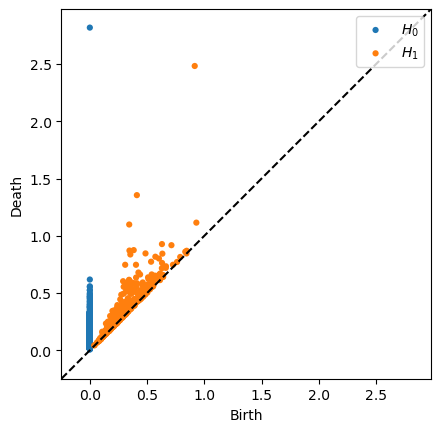

2125

In [37]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new_crop)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
plt.figure()
plot_diagrams(persistence["dgms"], plot_only=np.arange(maxdim + 1))
plt.show()

diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

f_new = get_coords(cocycle, threshold, len(layout3), M, 47)

len(f_new[0])

In [38]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_new[:, 0],
            y=layout_3d_new[:, 1],
            z=layout_3d_new[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new[0],
                colorscale="Viridis",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D.html")
fig.show()

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [39]:
linsp = np.linspace(0, 1, 51)

clusters_overlap = []
for a in range(1, 50):
    c = []
    for p in range(len(f_new[0])):
        if linsp[a - 1] < f_new[0][p] < linsp[a + 1]:
            c.append(cluster_new_crop[p])
    print(linsp[a - 1])
    print(linsp[a + 1])
    clusters_overlap.append(c)
c = []
for p in range(len(f)):
    if linsp[49] < f[p] or f[p] < linsp[1]:
        c.append(cluster_new_crop[p])
print(linsp[49])
print(linsp[1])
clusters_overlap.append(c)

av_clusters_overlap = []
for p in range(len(clusters_overlap)):
    av_clusters_overlap.append(np.mean(clusters_overlap[p], axis=0))

0.0
0.04
0.02
0.06
0.04
0.08
0.06
0.1
0.08
0.12
0.1
0.14
0.12
0.16
0.14
0.18
0.16
0.2
0.18
0.22
0.2
0.24
0.22
0.26
0.24
0.28
0.26
0.3
0.28
0.32
0.3
0.34
0.32
0.36
0.34
0.38
0.36
0.4
0.38
0.42
0.4
0.44
0.42
0.46
0.44
0.48
0.46
0.5
0.48
0.52
0.5
0.54
0.52
0.56
0.54
0.58
0.56
0.6
0.58
0.62
0.6
0.64
0.62
0.66
0.64
0.68
0.66
0.7000000000000001
0.68
0.72
0.7000000000000001
0.74
0.72
0.76
0.74
0.78
0.76
0.8
0.78
0.8200000000000001
0.8
0.84
0.8200000000000001
0.86
0.84
0.88
0.86
0.9
0.88
0.92
0.9
0.9400000000000001
0.92
0.96
0.9400000000000001
0.98
0.96
1.0


IndexError: index 2146 is out of bounds for axis 0 with size 2125

Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.15it/s]



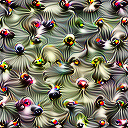

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.05it/s]



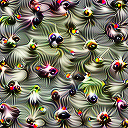

100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.05it/s]



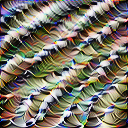

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.98it/s]



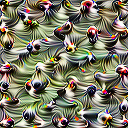

100%|█████████████████████████████████████████| 512/512 [00:52<00:00,  9.75it/s]



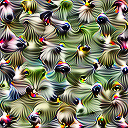

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.72it/s]



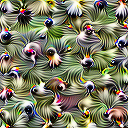

100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.06it/s]



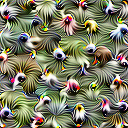

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.75it/s]



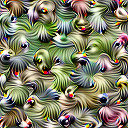

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.31it/s]



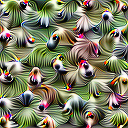

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.68it/s]



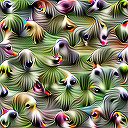

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.14it/s]



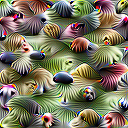

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.78it/s]



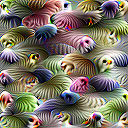

100%|█████████████████████████████████████████| 512/512 [00:53<00:00,  9.53it/s]



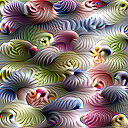

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.77it/s]



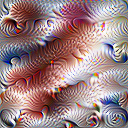

100%|█████████████████████████████████████████| 512/512 [00:54<00:00,  9.40it/s]



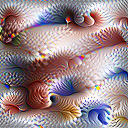

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.81it/s]



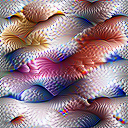

100%|█████████████████████████████████████████| 512/512 [00:51<00:00,  9.88it/s]



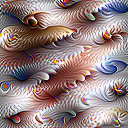

100%|█████████████████████████████████████████| 512/512 [01:01<00:00,  8.32it/s]



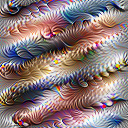

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.26it/s]



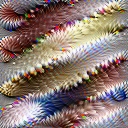

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.57it/s]



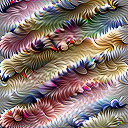

100%|█████████████████████████████████████████| 512/512 [00:54<00:00,  9.34it/s]



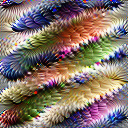

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.43it/s]



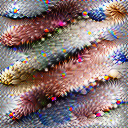

100%|█████████████████████████████████████████| 512/512 [00:53<00:00,  9.59it/s]



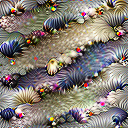

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



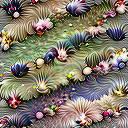

100%|█████████████████████████████████████████| 512/512 [00:57<00:00,  8.86it/s]



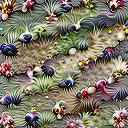

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.80it/s]



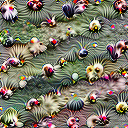

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.07it/s]



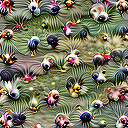

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



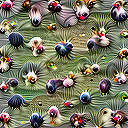

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.04it/s]



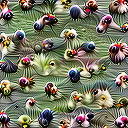

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



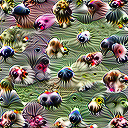

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.14it/s]



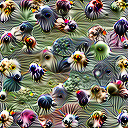

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.48it/s]



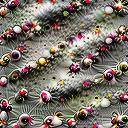

100%|█████████████████████████████████████████| 512/512 [00:57<00:00,  8.97it/s]



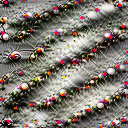

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.48it/s]



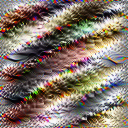

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.19it/s]



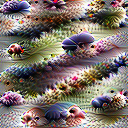

100%|█████████████████████████████████████████| 512/512 [01:31<00:00,  5.59it/s]



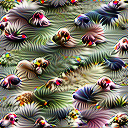

100%|█████████████████████████████████████████| 512/512 [03:26<00:00,  2.48it/s]



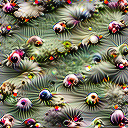

100%|█████████████████████████████████████████| 512/512 [01:01<00:00,  8.38it/s]



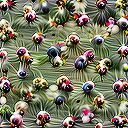

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.73it/s]



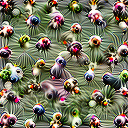

100%|█████████████████████████████████████████| 512/512 [00:58<00:00,  8.82it/s]



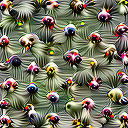

100%|█████████████████████████████████████████| 512/512 [00:54<00:00,  9.47it/s]



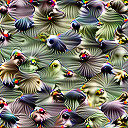

100%|█████████████████████████████████████████| 512/512 [01:01<00:00,  8.29it/s]



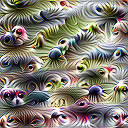

100%|█████████████████████████████████████████| 512/512 [00:51<00:00,  9.94it/s]



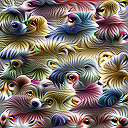

100%|█████████████████████████████████████████| 512/512 [01:00<00:00,  8.52it/s]



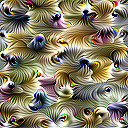

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.29it/s]



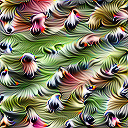

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.00it/s]



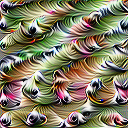

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.43it/s]



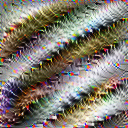

100%|█████████████████████████████████████████| 512/512 [00:58<00:00,  8.76it/s]



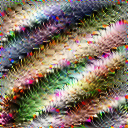

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.69it/s]



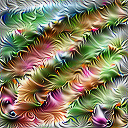

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.74it/s]



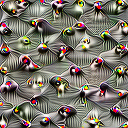

In [39]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True)
model.eval()

pics = []
channel = lambda n: objectives.channel("inception4a", n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

100%|██████████| 512/512 [01:32<00:00,  5.51it/s]



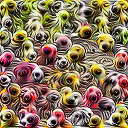

In [49]:
a = []
for m in range(len(high_inform)):
    a.append(av_clusters_overlap[49][m] * channel(high_inform[m]))
obj = sum(a)
d = render.render_vis(model, obj, show_inline=True)

In [48]:
len(av_clusters_overlap)

50